In [2]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tiffile import imsave
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from numpy import ndarray
    

2022-02-25 14:43:13.302329: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.5/lib:/usr/local/cuda-11.5/lib64
2022-02-25 14:43:13.302346: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
g = sorted(glob.glob('/media/jainy/project/Depanshu_project/data__/train/glioma_tumor/*.jpg'))
m = sorted(glob.glob('/media/jainy/project/Depanshu_project/data__/train/meningioma_tumor/*.jpg'))
n = sorted(glob.glob('/media/jainy/project/Depanshu_project/data__/train/no_tumor/*.jpg'))
p = sorted(glob.glob('/media/jainy/project/Depanshu_project/data__/train/pituitary_tumor/*.jpg'))


In [3]:
#! /usr/bin/env python
# -*- coding: utf-8 -*-

import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_math_ops


def tf_batch_gather(params, indices, axis, name=None):
    """
    Extension of the batch_gather function in tensorflow
    (see https://github.com/tensorflow/tensorflow/blob/r1.13/tensorflow/python/ops/array_ops.py
    or https://www.tensorflow.org/api_docs/python/tf/batch_gather)
    Gather slices from `params` according to `indices` with leading batch dims.
    This operation assumes that the leading dimensions of `indices` are dense,
    and the gathers on the axis corresponding to the last dimension of `indices`.
    More concretely it computes:
    `result[i1, ..., in, j1, ..., jm, k1, ...., kl] = params[i1, ..., in, indices[i1, ..., in, j1, ..., jm], k1, ..., kl]`
    Therefore `params` should be a Tensor of shape [A1, ..., AN, C0, B1, ..., BM],
    `indices` should be a Tensor of shape [A1, ..., AN, C1, ..., CK] and `result` will be
    a Tensor of size `[A1, ..., AN, C1, ..., CK, B1, ..., BM]`.
    In the case in which indices is a 1D tensor, this operation is equivalent to
    `tf.gather`.
    See also `tf.gather` and `tf.gather_nd`.
    Args:
      params: A `Tensor`. The tensor from which to gather values.
      indices: A `Tensor`. Must be one of the following types: int32, int64. Index
          tensor. Must be in range `[0, params.shape[axis]`, where `axis` is the
          last dimension of `indices` itself.
      axis: A `Tensor`. Must be one of the following types: int32, int64. The axis
            in `params` to gather `indices` from.
      name: A name for the operation (optional).
    Returns:
      A Tensor. Has the same type as `params`.
    Raises:
      ValueError: if `indices` has an unknown shape.
    """

    with ops.name_scope(name):
        indices = ops.convert_to_tensor(indices, name="indices")
        params = ops.convert_to_tensor(params, name="params")
        indices_shape = tf.shape(indices)
        params_shape = tf.shape(params)

        ndims = indices.shape.ndims
        if ndims is None:
            raise ValueError("batch_gather does not allow indices with unknown "
                             "shape.")
        batch_indices = indices
        indices_dtype = indices.dtype.base_dtype
        accum_dim_value = tf.ones((), dtype=indices_dtype)
        # Use correct type for offset index computation
        casted_params_shape = gen_math_ops.cast(params_shape, indices_dtype)
        for dim in range(axis, 0, -1):
            dim_value = casted_params_shape[dim - 1]
            accum_dim_value *= casted_params_shape[dim]
            start = tf.zeros((), dtype=indices_dtype)
            step = tf.ones((), dtype=indices_dtype)
            dim_indices = gen_math_ops._range(start, dim_value, step)
            dim_indices *= accum_dim_value
            dim_shape = tf.stack([1] * (dim - 1) + [dim_value] + [1] * (ndims - dim),
                                 axis=0)
            batch_indices += tf.reshape(dim_indices, dim_shape)

        flat_inner_shape_indices = gen_math_ops.prod(indices_shape[:(axis + 1)], [0], False)
        flat_indices = tf.reshape(batch_indices, tf.concat([[flat_inner_shape_indices],
                                                            indices_shape[(axis + 1):]], axis=0))
        outer_shape = params_shape[(axis + 1):]
        flat_inner_shape_params = gen_math_ops.prod(params_shape[:(axis + 1)], [0], False)

        flat_params = tf.reshape(params, tf.concat([[flat_inner_shape_params], outer_shape], axis=0))
        flat_result = tf.gather(flat_params, flat_indices)
        result = tf.reshape(flat_result, tf.concat([indices_shape, outer_shape], axis=0))
        final_shape = indices.get_shape()[:axis].merge_with(
                params.get_shape()[:axis])
        final_shape = final_shape.concatenate(indices.get_shape()[axis:])
        final_shape = final_shape.concatenate(params.get_shape()[(axis + 1):])
        result.set_shape(final_shape)
        return result


def tf_batch_histogram(values, value_range, axis, nbins=100, dtype=tf.int32, use_map=True):
    """
    Computes histogram with fixed width considering batch dimensions
    :param values: Numeric `Tensor` containing the values for histogram computation.
    :param value_range: Shape [2] `Tensor` of same `dtype` as `values`. values <= value_range[0] will be mapped to
    hist[0], values >= value_range[1] will be mapped to hist[-1].
    :param axis: Number of batch dimensions. First axis to apply histogram computation to.
    :param nbins: Scalar `int32 Tensor`. Number of histogram bins.
    :param dtype: dtype for returned histogram, can be either tf.int32 or tf.int64.
    :return: histogram with batch dimensions.
    """

    # Get shape
    values_shape = tf.shape(values)
    batch_dim = values_shape[:axis]
    rest_dim = values_shape[axis:]
    num_batch = tf.reduce_prod(batch_dim)

    if use_map:
        values_reshaped = tf.reshape(values, tf.concat([[num_batch], rest_dim], 0))
        hist = tf.map_fn(lambda x: tf.histogram_fixed_width(x, value_range, nbins=nbins, dtype=dtype), values_reshaped,
                         dtype=dtype, parallel_iterations=64)
    else:
        # Normalize
        values_float = tf.cast(values, tf.float32)
        value_range_float = tf.cast(value_range, tf.float32)

        # Clip values
        values_norm = (values_float - value_range_float[0]) / (value_range_float[1] - value_range_float[0])
        values_clip1 = tf.maximum(values_norm, 0.5 / tf.cast(nbins, tf.float32))
        values_clip2 = tf.minimum(values_clip1, 1.0 - 0.5 / tf.cast(nbins, tf.float32))

        # Shift values
        values_shift = values_clip2 + tf.reshape(tf.range(tf.cast(num_batch, tf.float32), dtype=tf.float32),
                                                 tf.concat([batch_dim, tf.ones(tf.size(rest_dim), tf.int32)], 0))

        # Get histogram
        hist = tf.histogram_fixed_width(values_shift, [0., tf.cast(num_batch, tf.float32)], nbins=num_batch * nbins,
                                        dtype=dtype)

    return tf.reshape(hist, tf.concat([batch_dim, [nbins]], 0))

In [4]:
import numpy as np
import tensorflow as tf
from keras.utils import *


from itertools import product

def mclahe(x, kernel_size=None, n_bins=128, clip_limit=0.01, adaptive_hist_range=False, use_gpu=False):
    """
    Contrast limited adaptive histogram equalization implemented in tensorflow
    :param x: numpy array to which clahe is applied
    :param kernel_size: tuple of kernel sizes, 1/8 of dimension lengths of x if None
    :param n_bins: number of bins to be used in the histogram
    :param clip_limit: relative intensity limit to be ignored in the histogram equalization
    :param adaptive_hist_range: flag, if true individual range for histogram computation of each block is used
    :param use_gpu: Flag, if true gpu is used for computations if available
    :return: numpy array to which clahe was applied, scaled on interval [0, 1]
    """

    if kernel_size is None:
        kernel_size = tuple(s // 8 for s in x.shape)
    kernel_size = np.array(kernel_size)

    assert len(kernel_size) == len(x.shape)

    dim = len(x.shape)

    # Normalize data
    x_min = np.min(x)
    x_max = np.max(x)
    x = (x - x_min) / (x_max - x_min)

    # Pad data
    x_shape = np.array(x.shape)
    padding_x_length = kernel_size - 1 - ((x_shape - 1) % kernel_size)
    padding_x = np.column_stack(((padding_x_length + 1) // 2, padding_x_length // 2))
    padding_hist = np.column_stack((kernel_size // 2, (kernel_size + 1) // 2)) + padding_x
    x_hist_padded = np.pad(x, padding_hist, 'symmetric')

    # Set up tf graph
    #tf.compat.v1.disable_eager_execution()
    with tf.compat.v1.variable_scope("clahe") as scope:
        tf_x_hist_padded_init = tf.compat.v1.placeholder(tf.float32, shape=x_hist_padded.shape)
        tf_x_hist_padded = tf.Variable(tf_x_hist_padded_init)
        tf_x_padded = tf.slice(tf_x_hist_padded, kernel_size // 2, x_shape + padding_x_length)

        # Form blocks used for interpolation
        n_blocks = np.ceil(np.array(x.shape) / kernel_size).astype(np.int32)
        new_shape = np.reshape(np.column_stack((n_blocks, kernel_size)), (2 * dim,))
        perm = tuple(2 * i for i in range(dim)) + tuple(2 * i + 1 for i in range(dim))
        tf_x_block = tf.transpose(tf.reshape(tf_x_padded, new_shape), perm=perm)
        shape_x_block = np.concatenate((n_blocks, kernel_size))

        # Form block used for histogram
        n_blocks_hist = n_blocks + np.ones(dim, dtype=np.int32)
        new_shape = np.reshape(np.column_stack((n_blocks_hist, kernel_size)), (2 * dim,))
        perm = tuple(2 * i for i in range(dim)) + tuple(2 * i + 1 for i in range(dim))
        tf_x_hist = tf.transpose(tf.reshape(tf_x_hist_padded, new_shape), perm=perm)

        # Get maps
        # Get histogram
        if adaptive_hist_range:
            hist_ex_shape = np.concatenate((n_blocks_hist, [1] * dim))
            tf_x_hist_ex_init = tf.placeholder(tf.float32, shape=n_blocks_hist)
            tf_x_hist_min = tf.Variable(tf_x_hist_ex_init, dtype=tf.float32)
            tf_x_hist_max = tf.reduce_max(tf_x_hist, np.arange(-dim, 0))
            tf_x_hist_norm = tf.Variable(tf_x_hist_ex_init, dtype=tf.float32)
            tf_get_hist_min = tf.assign(tf_x_hist_min, tf.reduce_min(tf_x_hist, np.arange(-dim, 0)))
            tf_get_hist_norm = tf.assign(tf_x_hist_norm, tf.where(tf.equal(tf_x_hist_min, tf_x_hist_max),
                                                                  tf.ones_like(tf_x_hist_min),
                                                                  tf_x_hist_max - tf_x_hist_min))

            tf_x_hist_scaled = (tf_x_hist - tf.reshape(tf_x_hist_min, hist_ex_shape))\
                               / tf.reshape(tf_x_hist_norm, hist_ex_shape)
        else:
            tf_x_hist_scaled = tf_x_hist
        tf_hist = tf.cast(tf_batch_histogram(tf_x_hist_scaled, [0., 1.], dim, nbins=n_bins), tf.float32)
        # Clip histogram
        tf_n_to_high = tf.reduce_sum(tf.nn.relu(tf_hist - np.prod(kernel_size) * clip_limit), -1, keepdims=True)
        tf_hist_clipped = tf.minimum(tf_hist, np.prod(kernel_size) * clip_limit) + tf_n_to_high / n_bins
        tf_cdf = tf.cumsum(tf_hist_clipped, -1)
        tf_cdf_slice_size = tf.constant(np.concatenate((n_blocks_hist, [1])), tf.int32)
        tf_cdf_min = tf.slice(tf_cdf, tf.constant([0] * (dim + 1), dtype=tf.int32), tf_cdf_slice_size)
        tf_cdf_max = tf.slice(tf_cdf, tf.constant([0] * dim + [n_bins - 1], dtype=tf.int32), tf_cdf_slice_size)
        tf_cdf_norm = tf.where(tf.equal(tf_cdf_min, tf_cdf_max), tf.ones_like(tf_cdf_max), tf_cdf_max - tf_cdf_min)
        tf_mapping = (tf_cdf - tf_cdf_min) / tf_cdf_norm

        map_shape = np.concatenate((n_blocks_hist, [n_bins]))
        tf_map_init = tf.compat.v1.placeholder(tf.float32, shape=map_shape)
        tf_map = tf.Variable(tf_map_init, dtype=tf.float32)
        tf_get_map = tf.compat.v1.assign(tf_map, tf_mapping)

        # Prepare initializer
        tf_x_block_init = tf.compat.v1.placeholder(tf.float32, shape=shape_x_block)

        # Set up slice of data and map
        tf_slice_begin = tf.compat.v1.placeholder(tf.int32, shape=(dim,))
        tf_map_slice_begin = tf.concat([tf_slice_begin, [0]], 0)
        tf_map_slice_size = tf.constant(np.concatenate((n_blocks, [n_bins])), dtype=tf.int32)
        tf_map_slice = tf.slice(tf_map, tf_map_slice_begin, tf_map_slice_size)
        # Get bins
        if adaptive_hist_range:
            # Local bins
            tf_hist_norm_slice_shape = np.concatenate((n_blocks, [1] * dim))
            tf_x_hist_min_sub = tf.slice(tf_x_hist_min, tf_slice_begin, n_blocks)
            tf_x_hist_norm_sub = tf.slice(tf_x_hist_norm, tf_slice_begin, n_blocks)
            tf_x_block_scaled = (tf_x_block - tf.reshape(tf_x_hist_min_sub, tf_hist_norm_slice_shape))\
                                / tf.reshape(tf_x_hist_norm_sub, tf_hist_norm_slice_shape)
            tf_bin = tf.histogram_fixed_width_bins(tf_x_block_scaled, [0., 1.], nbins=n_bins)
        else:
            # Global bins
            tf_bin = tf.Variable(tf.cast(tf_x_block_init, tf.int32), dtype=tf.int32)
            tf_get_bin = tf.compat.v1.assign(tf_bin, tf.histogram_fixed_width_bins(tf_x_block, [0., 1.], nbins=n_bins))
        # Apply map
        tf_mapped_sub = tf_batch_gather(tf_map_slice, tf_bin, dim)
        # Apply coefficients
        tf_coeff = tf.compat.v1.placeholder(tf.float32)
        tf_res_sub = tf.Variable(tf_x_block_init, dtype=tf.float32)
        tf_apply_map = tf.compat.v1.assign(tf_res_sub, tf_mapped_sub)
        tf_apply_coeff = tf.compat.v1.assign(tf_res_sub, tf_coeff * tf_res_sub)
        # Update results
        tf_res = tf.Variable(tf_x_block_init, dtype=tf.float32)
        tf_update_res = tf.compat.v1.assign_add(tf_res, tf_res_sub)

        # Rescaling
        tf_res_min, tf_res_max = (tf.reduce_min(tf_res), tf.reduce_max(tf_res))
        tf_res_norm = (tf_res - tf_res_min) / (tf_res_max - tf_res_min)
        tf_rescale = tf.compat.v1.assign(tf_res, tf_res_norm)

        # Reshape result
        new_shape = tuple((axis, axis + dim) for axis in range(dim))
        new_shape = tuple(j for i in new_shape for j in i)
        tf_res_transposed = tf.transpose(tf_res, new_shape)
        tf_res_reshaped = tf.reshape(tf_res_transposed, tuple(n_blocks[axis] * kernel_size[axis] for axis in range(dim)))

        # Recover original size
        tf_res_cropped = tf.slice(tf_res_reshaped, padding_x[:, 0], x.shape)

        # Setting up tf session
        if use_gpu:
            config = None
        else:
            config = tf.compat.v1.ConfigProto(device_count={'GPU': 0})

        with tf.compat.v1.Session(config=config) as sess:
            map_init = np.zeros(map_shape, dtype=np.float32)
            x_block_init = np.zeros(shape_x_block, dtype=np.float32)
            # Initialize vars for local hist range if needed
            if adaptive_hist_range:
                x_hist_ex_init = np.zeros(n_blocks_hist, dtype=np.float32)
                tf_var_init = tf.compat.v1.initializers.variables([tf_x_hist_padded, tf_map, tf_res, tf_res_sub,
                                                         tf_x_hist_min, tf_x_hist_norm])
                sess.run(tf_var_init, feed_dict={tf_x_hist_padded_init: x_hist_padded,
                                                 tf_map_init: map_init, tf_x_block_init: x_block_init,
                                                 tf_x_hist_ex_init: x_hist_ex_init})
            else:
                tf_var_init = tf.compat.v1.initializers.variables([tf_x_hist_padded, tf_map, tf_bin, tf_res, tf_res_sub])
                sess.run(tf_var_init, feed_dict={tf_x_hist_padded_init: x_hist_padded, tf_map_init: map_init,
                                                 tf_x_block_init: x_block_init})

            # Run calculations
            # Normalize histogram data if needed
            if adaptive_hist_range:
                sess.run(tf_get_hist_min)
                sess.run(tf_get_hist_norm)
            sess.run(tf_get_map)
            # Get global hist bins if needed
            if not adaptive_hist_range:
                sess.run(tf_get_bin)
            # Loop over maps
            inds = [list(i) for i in product([0, 1], repeat=dim)]
            for ind_map in inds:
                sess.run(tf_apply_map, feed_dict={tf_slice_begin: ind_map})
                # Calculate and apply coefficients
                for axis in range(dim):
                    coeff = np.arange(kernel_size[axis], dtype=np.float32) / kernel_size[axis]
                    if kernel_size[axis] % 2 == 0:
                        coeff = 0.5 / kernel_size[axis] + coeff
                    if ind_map[axis] == 0:
                        coeff = 1. - coeff
                    new_shape = [1] * (dim + axis) + [kernel_size[axis]] + [1] * (dim - 1 - axis)
                    coeff = np.reshape(coeff, new_shape)
                    sess.run(tf_apply_coeff, feed_dict={tf_coeff: coeff})
                # Update results
                sess.run(tf_update_res)

            # Rescaling
            sess.run(tf_rescale)

            # Get result
            result = sess.run(tf_res_cropped)

    return result

In [12]:
for img in range(len(g)):   
    print("Now preparing image and masks number: ", img)
      
    gl=np.array(g[img])
    
   
    
    
    
    print("Save Me")
    output_filename = 'image_'+str(img)+'.npy'
    
    np.save('data__/ggg/image_'+str(img)+'.npy', gl)

TypeError: len() of unsized object

In [ ]:
    mg=np.array(m[img])
    no=np.array(n[img])
    pi=np.array(p[img])
    np.save('data__/mmm/image_'+str(img)+'.npy', mg)
    np.save('data__/nnn/image_'+str(img)+'.npy', no)
    np.save('data__/ppp/image_'+str(img)+'.npy', pi)

In [5]:
for img in range(len(t2_list)):   
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=mclahe(temp_image_t2)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=mclahe(temp_image_t1ce)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=mclahe(temp_image_flair)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  
    
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
  
    #cropping x, y, and z into size 192*192*128
    temp_combined_images=temp_combined_images[24:216, 24:216, 13:141]
    temp_mask = temp_mask[24:216, 24:216, 13:141]
    
    
    print("Save Me")
    output_filename = 'image_'+str(img)+'.npy'
    temp_mask= to_categorical(temp_mask, num_classes=4)
    np.save('data__/tr/image_'+str(img)+'.npy', temp_combined_images)
    
        
    

NameError: name 't2_list' is not defined

In [12]:
import splitfolders  

input_folder = 'brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels_mclahe/'
output_folder = 'brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/'

splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 738 files [11:02,  1.11 files/s]


In [3]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

      
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y)      

            batch_start += batch_size   
            batch_end += batch_size

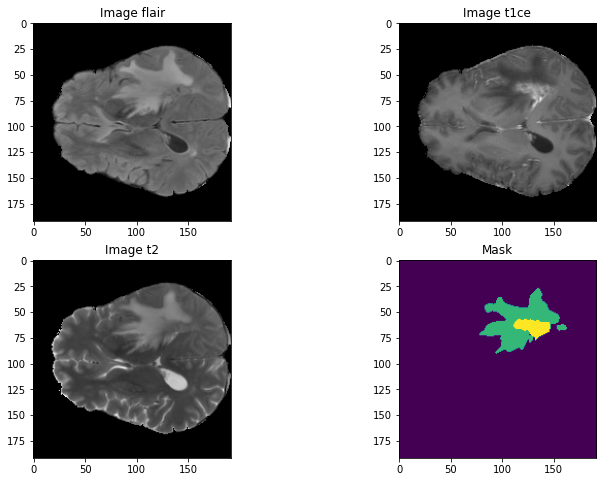

In [31]:



from matplotlib import pyplot as plt
import random

train_img_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/train/images/"
train_mask_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_1284/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)


img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)
 
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

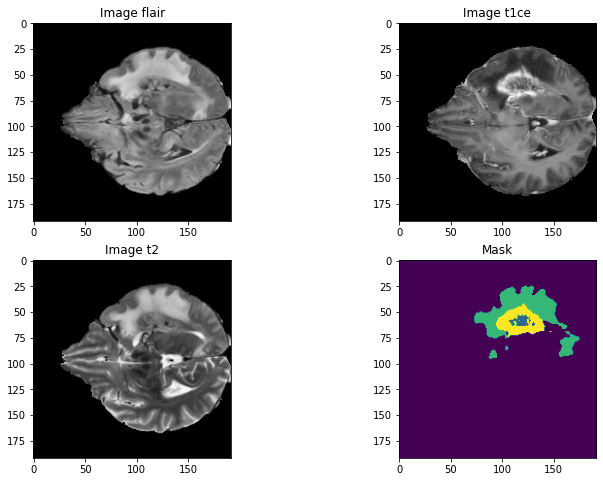

In [32]:
from matplotlib import pyplot as plt
import random

train_img_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/train/images/"
train_mask_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)


img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)
 
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [33]:
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU

kernel_initializer =  'he_uniform' 



def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    
    s = inputs

    
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)
     
    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
     
    model.summary()
    
    return model

 
model = simple_unet_model(192, 192, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 192, 192, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 192, 192, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

2022-02-25 09:26:16.435760: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-25 09:26:16.435836: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jainy): /proc/driver/nvidia/version does not exist
2022-02-25 09:26:16.436392: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [34]:
train_img_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/train/images/"
train_mask_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/train/masks/"

val_img_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/val/images/"
val_mask_dir = "brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)


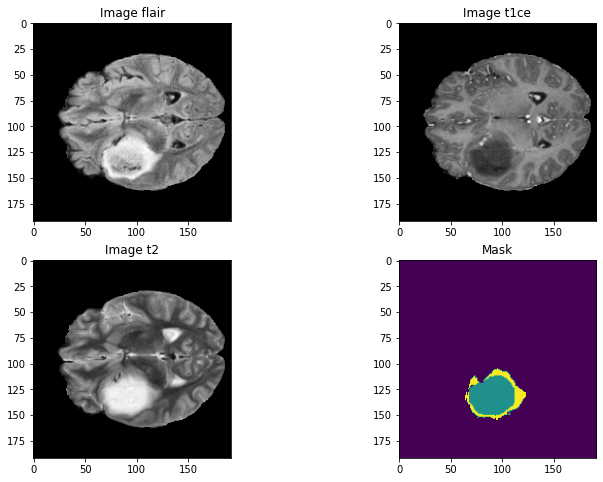

In [42]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)


img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [43]:
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
import segmentation_models_3D as sm
from tensorflow.keras.optimizers import Adam

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = Adam(LR)

Segmentation Models: using `tf.keras` framework.


In [44]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size




model = simple_unet_model(IMG_HEIGHT=192, 
                          IMG_WIDTH=192, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 192, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 192, 192, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout_9 (Dropout)            (None, 192, 192, 12  0           ['conv3d_19[0][0]']              
                                8, 16)                                                      

In [ ]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=5,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('Seg_BraTS_3d_mclahe.hdf5')

Epoch 1/5


2022-02-25 09:27:54.265011: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8153726976 exceeds 10% of free system memory.
2022-02-25 09:27:54.265050: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8153726976 exceeds 10% of free system memory.
2022-02-25 09:28:02.206527: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16307453952 exceeds 10% of free system memory.
2022-02-25 09:28:02.206582: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 16307453952 exceeds 10% of free system memory.
2022-02-25 09:28:45.656575: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 8153726976 exceeds 10% of free system memory.


 60/138 [============>.................] - ETA: 1:26:07 - loss: 0.9579 - accuracy: 0.8567 - iou_score: 0.1821

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#############################################
#Predict on a few test images, one at a time
#Try images: 
img_num = 83

test_img = np.load("brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_mclahe/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))





In [ ]:
#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 50
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()
